In [8]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from IPython.display import Video
from scipy.io import wavfile
from Kildekode._07_Frekvensanalyse import *

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Effektspekter og Spektrogram

* **Emne AIS2201 - Signalbehandling**
* **Uke 38, 2024**
* **Underviser: Kai Erik Hoff**

# Tema:

* Signalenergi og effekt
* Effektspekter intro
* Periodogram - et enkelt estimat for effektspekter
    * Anvendelser av effektspekter
* Spektrogram
    * Overlappende signalsegment
    * Anvendelser av spektrogram

# Signalenergi og effekt
<img src="Figurer/07_Frekvensanalyse/Fig18_PSD2.png" style="width: 80%; margin-left=100px" />

# Effektspekter
* Forteller hvordan den totale effekten til et signal er fordelt over hele frekvensspekteret
* Notasjon for analoge signal:
$$S_{xx}(f)$$
* Relasjon til signaleffekt:
$$P_x = E(|x(t)|^2) = \int_0^{\infty} S_{xx}(f) df$$

# Effektspekter



<img src="Figurer/07_Frekvensanalyse/Fig17_PSD1.png" style="width: 80%; margin-left=100px" />

# Periodogram

* Enkleste estimat av effektspekter
$$ P_{xx}(f_m) = \frac{1}{N\cdot f_s} \left| X[m] \right| ^2, \ \ \ \ \ f_m \in f_s \cdot \frac{m}{N} $$
    * Tar ofte i bruk vindusfunksjoner for å motvirke spektral lekkasje
    * Husk å kompensere for "tapt effekt" fra vindusfunksjoner.


* Utregning med python: [`scipy.signal.periodogram()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html):
```python
f_m, P_xx = scipy.signal.periodogram(xn, # Signal-array
                                       fs, # Samplingsfrekvens
                                       window, # Vindusfunksjon
                                       nfft    # Oppløsning etter zero padding
                                      )
```

* Her er en veldig fin videoforklaring på magnitudespekter vs. effekstpekter vs. spektraltetthet: [https://www.youtube.com/watch?v=pfjiwxhqd1M](https://www.youtube.com/watch?v=pfjiwxhqd1M)

## Kodeeksempel: frekvensanalyse av lydsignal

* Regn ut effektspekteret til et utsnitt av signalet `orca.wav` som starter i $t=0.25s$.
    * Vi velger passende vinduslengde selv.

(0.0, 11022.308349609375)

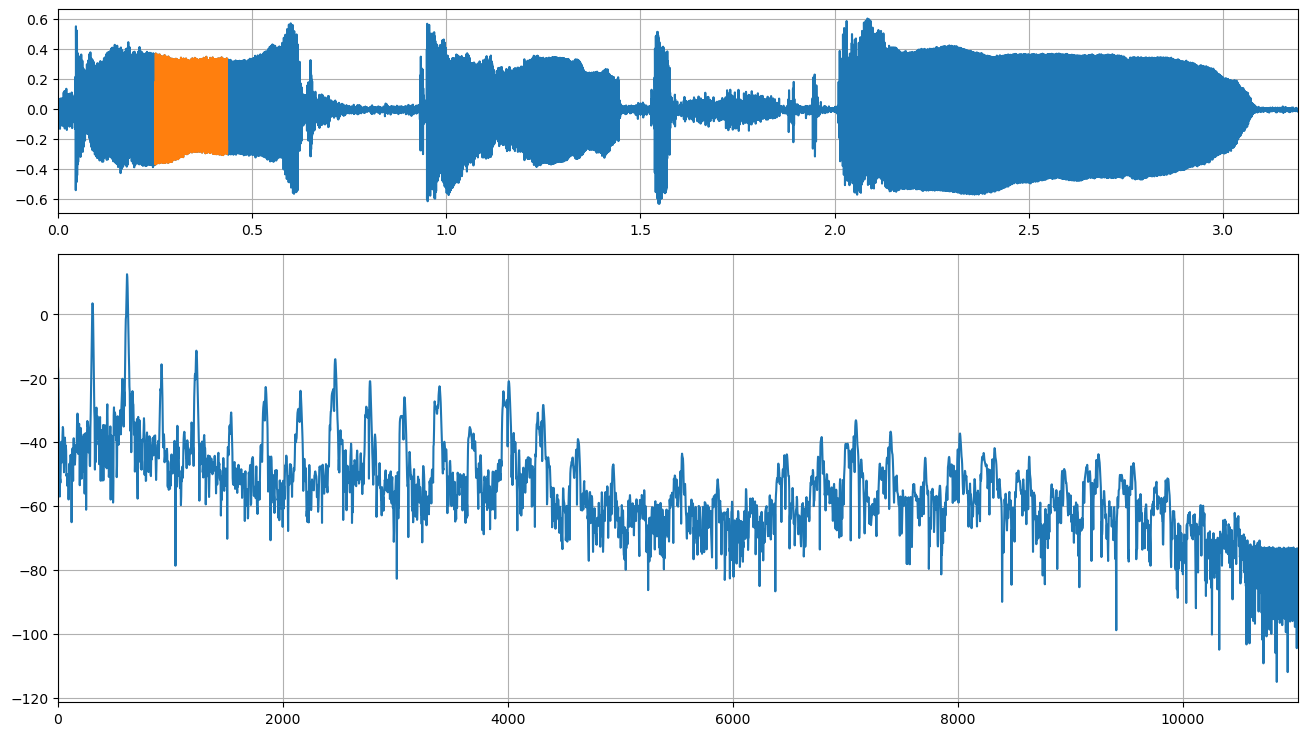

In [14]:
%matplotlib inline
import scipy.signal as sig
from IPython.display import Audio

fs, data = wavfile.read(r'Datafiler/04_Frekvensrepresentasjon/orca.wav') # les audiofilen 'orca.wav' og lagre til variablene 'fs' og 'data'
xn = data/0x8000

t_1 = 0.25 # sekund
n_1 = int(fs * t_1) # samplenummer

N = 4096 # Lengde på vindu

xn_part = xn[n_1:n_1+N]
xn_wn = xn_part*(0.54 - 0.46*cos(2*pi*np.arange(N)/(N-1))) # scipy.signal.hamming(N)
xn_pad = np.concatenate([xn_wn, np.zeros(N)]) # Utfør zero padding

Xm = np.fft.fft(xn_pad) # Finn X[m]

Pxx = abs(Xm)**2/N  # Finn periodogram P_xx
Pxx = Pxx[0:len(Pxx)//2]


plt.figure(figsize=(16,9))
# Lag plot av signal over tid!
plt.subplot(3,1,1)
t = np.linspace(0, len(xn)/fs, len(xn), endpoint=False)
t_part = np.arange(n_1, n_1+N)/fs
plt.plot(t, xn)
plt.plot(t_part, xn_part)
plt.grid(True)
plt.xlim([t[0], t[-1]])
# Lag plot av Periodigram for utklipp av x[n]:
plt.subplot(3,1,(2,3))
M = len(Pxx)
f = np.linspace(0, fs//2, M, endpoint=False)
plt.plot(f, 10*np.log10(Pxx))
plt.grid(True)
plt.xlim([f[0], f[-1]])

# Ikke-stasjonære signal

* Begrep for signal der frekvensinnholdet varierer over tid
* De fleste signal varierer i komposisjon over tid. 
* Å utføre frekvensanalyse av hele signalet gjør at vi ikke kan fortelle noe om *når* de forskjellige frekvenskomponentene oppstår.
* Foreslått løsning:
    1. Del opp signalet i mindre segment
    2. Foreta frekvensanalyse av hvert segment for seg selv
    3. Kombiner frekvensinformasjonen fra alle segmentene til en 2-dimensjonal oversikt over hvilke frekvenskomponenter som forekommer, og når de er tilstede.


# Spektrogram

<img src="Figurer/08_Effektspekter_Spektrogram/Fig1_Spektrogram.png" style="width: 80%; margin-left=100px" />

# Utfordringer

* Oppløsningen i frekvensdomenet er proporsjonal med vinduslengden $N$.
* Presisjon i tidsdomenet er invers proporsjonal med vinduslengden $N$.


* Vi må med andre ord identifisere en vinduslengde som gir god nok oppløsning i frekvensdomenet, samtidig som vi har korte nok vinduslengder til at variasjoner i frekvensinnhold vil fanges opp.

* Det er allikevel noen triks vi kan ta i bruk for å få det meste ut av situasjonen.
    * Zero Padding og Vindusfunksjoner er to av de.

# Overlappende signalvindu

* Vi kan øke oppløsining i tidsaksen ved å "gjenbruke" en andel av de foregående vinduene.
    * 50% overlapping er vanlig
        * Gevinsten ved å bruke overlapping avtar desto større andel av vinduet som er "gjenbrukt informasjon"
        * Sikrer "optimal" utnyttelse av informasjon ved bruk av vindusfunksjoner


<img src="Figurer/08_Effektspekter_Spektrogram/Fig2_Spektrogram2.png" style="width: 80%; margin-left=100px" />

## Teoriquiz 1:
* Et signalopptak har en lengde på $L=40\ 000$ sampler. Det er ønskelig å generere et spektrogram der vinduslengden brukt i til frekvensanalye er $N=1\ 000$ sampler, og for å øke antallet "frames" i spektrogramemet benytter vi $50\%$ overlapping av signalvinduene.
    * For hvor mange individuelle tidsintervall vil vi få utregnet spektralinnhold? Sagt på en annen måte: hva blir det totale antallet signalvindu vi henter fra signalet?
    
Antall separate vindu:

$$ \frac{L}{N} \cdot 2 +1 = \frac{40000}{1000} \cdot 2 + 1 = 81$$

## Kodeeksempel: Spektrogram
* Lag et spektrogram som viser frekvensinnholdet til lydfilen `"orca.wav"` over tid.
    * Studer hvordan de ulike parametrene påvirker det utregnede spektrogrammet.

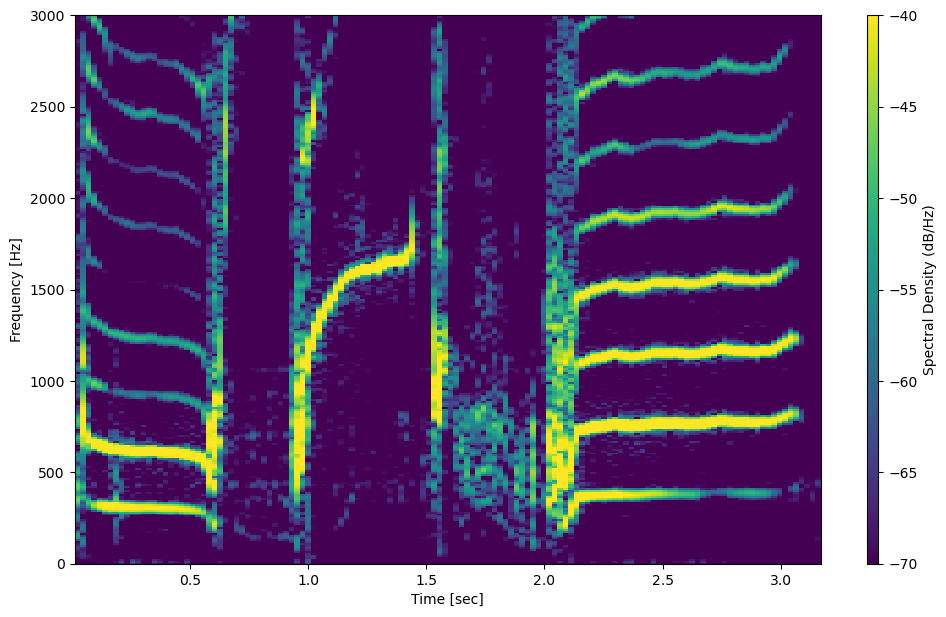

In [20]:
fs, data = wavfile.read(r'Datafiler/04_Frekvensrepresentasjon/orca.wav') # les audiofilen 'orca.wav' og lagre til variablene 'fs' og 'data'
xn = data/0x8000
N = 1024

f_axis, t_axis, S_xx = sig.spectrogram(xn, 
                             fs, 
                             window = 'hamming', 
                             nperseg = N, 
                             noverlap = N//2, 
                             nfft = 2*N
                            )

plt.close(3);plt.figure(3, figsize=(10,6))

plt.pcolormesh(t_axis,            # Array med tidsstempel. Produsert av spectrogram()
               f_axis,            # Array med frekvenser. Produsert av spectrogram()
               10*np.log10(S_xx),  # Konvertering av spektrogrammatrise til logaritmisk skala
               vmax =-40,         # Høyeste dB-verdi på fargekartet
               vmin = -70,        # Laveste dB-verdi på fargekartet
               shading='auto'
               )
plt.colorbar(aspect=50, label=r'Spectral Density (dB/Hz)')

plt.ylim([0, 3000]) # Du kan justere på grensene i y-aksen dersom du vil inspisere en spesiell del av plottet
#plt.xlim([0, 300]) # Du kan justere på grensene i x-aksen dersom du vil inspisere en spesiell del av plottet
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)
plt.show()
from IPython.display import Audio
Audio(xn, rate=fs)


# Anvendelser av spektrogram

* Kartlegging av interferens i radiosignal.
* Kartlegging av frekvensinnhold til et lydsignal / vibrasjonssignal o.l.
* Talegjenkjenning
    * Jeg vil sterkt anbefale [denne videoen](https://www.youtube.com/watch?v=N780rQIXSgc&t=448s) som viser hvordan spektrogram brukes til å pre-prosessere talesignal før en maskinlæingsalgoritme skal trenes til å gjenkjenne talesignalene.
* Mye mer...

# Signal med støy

* Utregnet effektspekter av signal med mye støy kan bli vanskelig å tyde.
* 

(-70.0, -7.775532707623395)

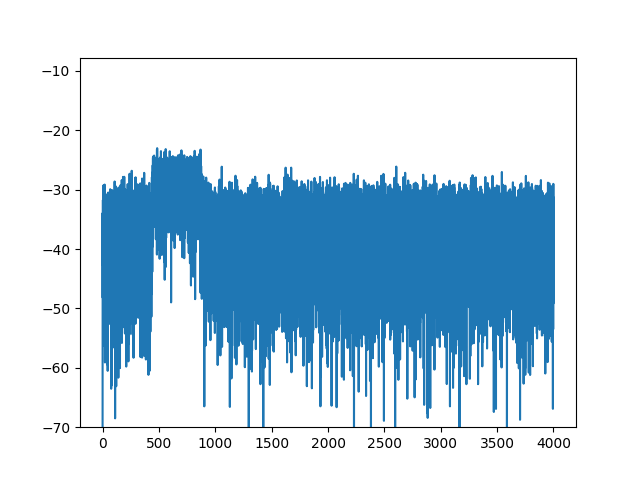

In [24]:
fs = 8000
T = 5 # Sekund
t = np.linspace(0, T, fs*T, endpoint=False)

signal = sig.chirp(t,f0 = 440, t1 = T, f1 = 880)
noise = np.random.normal(size=len(t))
x = signal+noise

f, S_xx = sig.periodogram(x, fs=fs)
plt.close(4);plt.figure(4)
plt.plot(f, 10*np.log10(S_xx))
plt.ylim(ymin=-70)

# Gjennomsnittet av flere effektspekter - Welch metoden

(-40.0, -27.282895605388426)

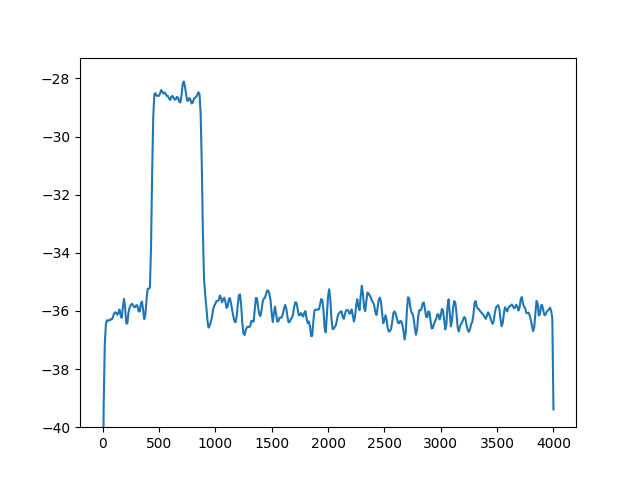

In [25]:
fs = 8000
T = 5 # Sekund
t = np.linspace(0, T, fs*T, endpoint=False)

signal = sig.chirp(t,f0 = 440, t1 = T, f1 = 880)
noise = np.random.normal(size=len(t))
x = signal+noise

f, S_xx = sig.welch(x, 
                    fs=fs, 
                    window="hamming",
                    nperseg = 400,
                    noverlap = 200,
                    nfft = 800)
plt.close(4);plt.figure(4)
plt.plot(f, 10*np.log10(S_xx))
plt.ylim(ymin=-40)

# Spørsmål?